IMPORT LIBRARY

In [250]:
# Install Library yang dibutuhkan
#%pip install TA-Lib
#%pip install bayesian-optimization

In [251]:
# Library
import pandas as pd
import numpy as np
from warnings import filterwarnings
filterwarnings ('ignore')

# Grafik dan Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Indikator Teknikal Saham
import talib

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error, r2_score

plt.rcParams['font.size'] = 13

DATA COLLECTION

In [252]:
# Memasukkan Data Olahan
path_data = r"D:\file\[KULIAHAN]\SKRIPSI\Resources\Data Olahan\BBCA_01102019_01102025.xlsx"
data = pd.read_excel(path_data, parse_dates=['Date'], index_col='Date')

# Melihat 10 Sampel Data Teratas
data.head(10)

,Open,High,Low,Close,Volume
Date,,,,,
2019-10-01,5212.767129,5260.471321,5212.767129,5238.787598,40057000.0
2019-10-02,5212.767466,5264.808406,5212.767466,5247.461426,52376500.0
2019-10-03,5212.767129,5243.124342,5160.726193,5238.787598,50269000.0
2019-10-04,5186.746829,5260.471491,5186.746829,5243.124512,56890500.0
2019-10-07,5264.808105,5273.481595,5247.461127,5264.808105,56705500.0
2019-10-08,5273.481634,5290.828613,5217.103952,5290.828613,46997500.0
2019-10-09,5290.828574,5290.828574,5247.461127,5264.808105,41496500.0
2019-10-10,5221.441031,5299.502441,5221.441031,5299.502441,65806500.0
2019-10-11,5273.481990,5338.533166,5273.481990,5312.512695,40863500.0


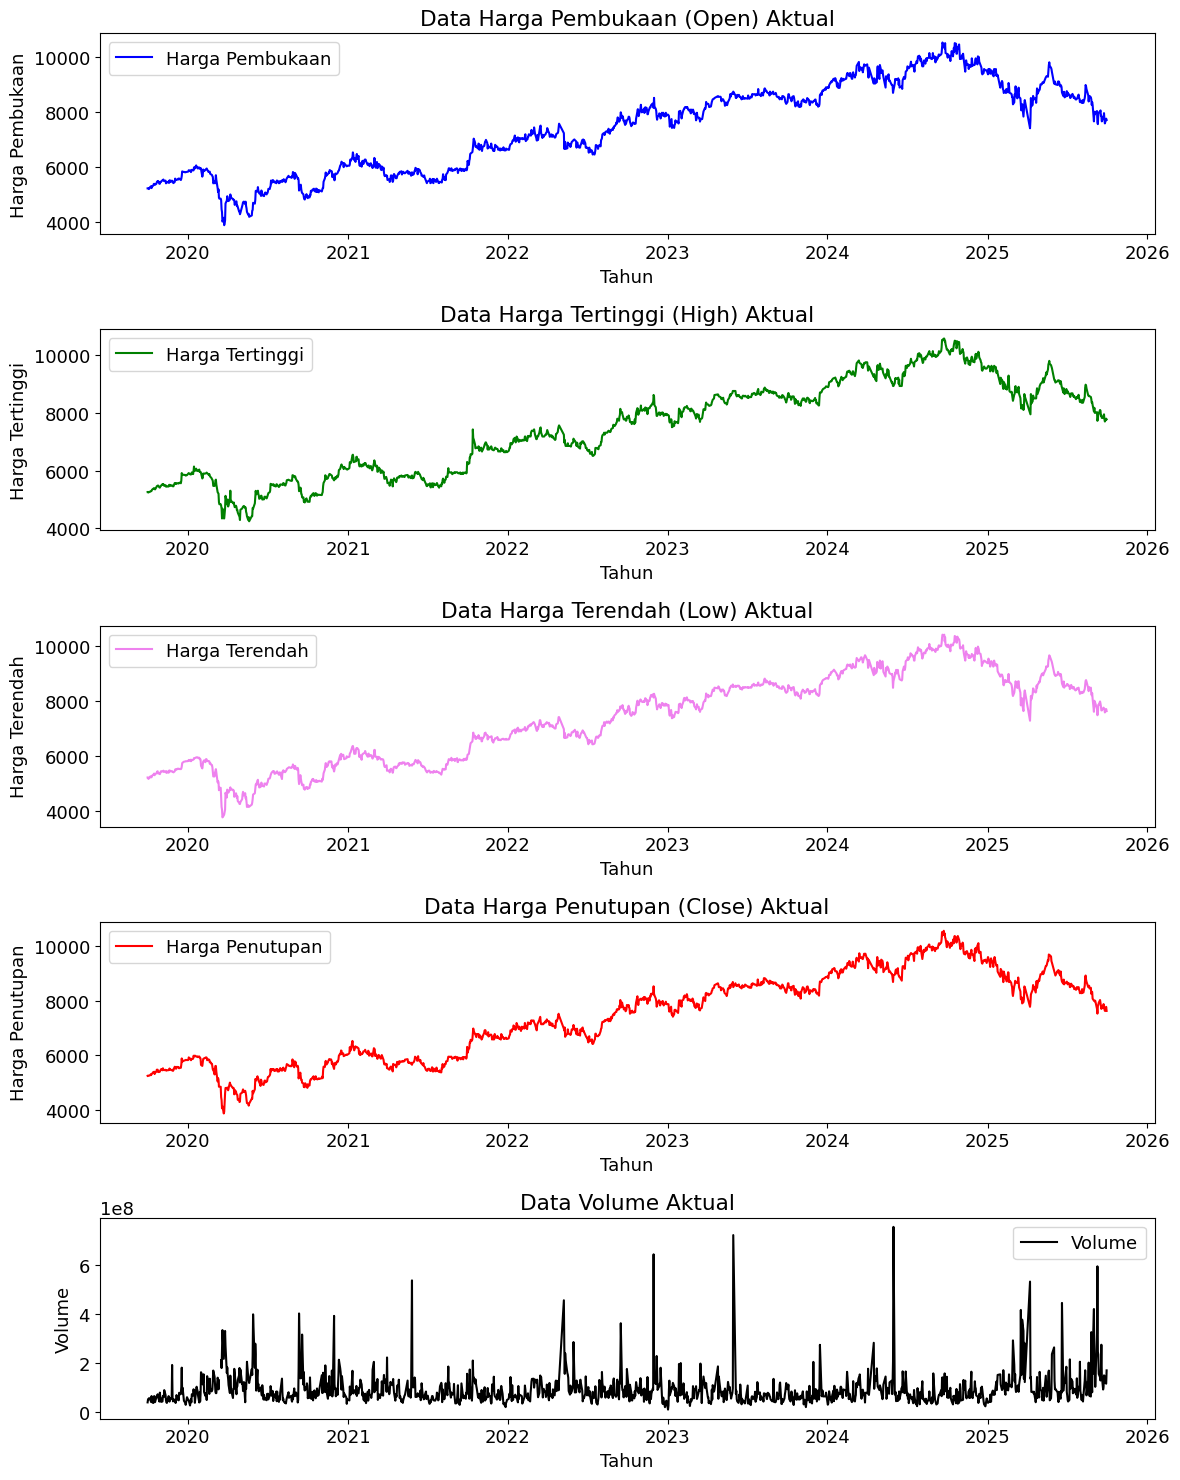

In [253]:
# Melakukan Visualisasi terhadap Masing-Masing Indikator
plt.figure(figsize=(12,15))

# Plotting Data dari Indikator 'Open'
plt.subplot(511)
plt.plot(data['Open'], label='Harga Pembukaan', color='blue')
plt.title('Data Harga Pembukaan (Open) Aktual')
plt.xlabel('Tahun')
plt.ylabel('Harga Pembukaan')
plt.legend()

# Plotting Data dari Indikator 'High'
plt.subplot(512)
plt.plot(data['High'], label='Harga Tertinggi', color='green')
plt.title('Data Harga Tertinggi (High) Aktual')
plt.xlabel('Tahun')
plt.ylabel('Harga Tertinggi')
plt.legend()

# Plotting Data dari Indikator 'Low'
plt.subplot(513)
plt.plot(data['Low'], label='Harga Terendah', color='violet')
plt.title('Data Harga Terendah (Low) Aktual')
plt.xlabel('Tahun')
plt.ylabel('Harga Terendah')
plt.legend()

# Plotting Data dari Indikator 'Close'
plt.subplot(514)
plt.plot(data['Close'], label='Harga Penutupan', color='red')
plt.title('Data Harga Penutupan (Close) Aktual')
plt.xlabel('Tahun')
plt.ylabel('Harga Penutupan')
plt.legend()

# Plotting Data dari Indikator 'Volume'
plt.subplot(515)
plt.plot(data['Volume'], label='Volume', color='black')
plt.title('Data Volume Aktual')
plt.xlabel('Tahun')
plt.ylabel('Volume')
plt.legend()

plt.tight_layout()

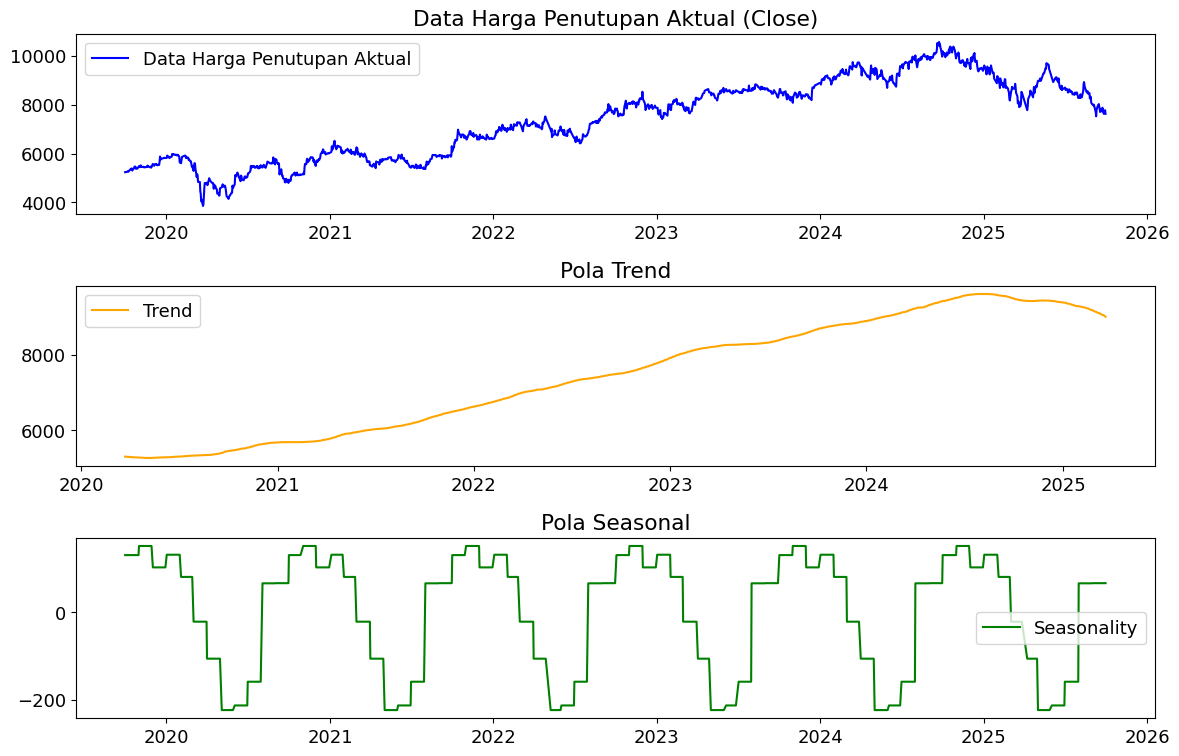

In [254]:
def dekomposisi_data_harian(data, visualisasi=True):
    df= pd.DataFrame(index=data.index)
    
    # Menghitung Moving Average
    df['Trend'] = data['Close'].rolling(window=240, center=True).mean() 
    # Menghitung Detrend
    df['Detrended'] = data['Close'] - df['Trend']
    # Menghitunga Seasonality
    seasonal_indices = df['Detrended'].groupby(data.index.month).mean()
    seasonal_indices = seasonal_indices - np.mean(seasonal_indices) # Seasonality berdistribusi normal
    
    df['Seasonal'] = data.index.month.map(seasonal_indices)
        
    if visualisasi:
        # Melakukan Plotting
        plt.figure(figsize=(12, 10))

        plt.subplot(411)
        plt.plot(data['Close'], label='Data Harga Penutupan Aktual', color='blue')
        plt.title('Data Harga Penutupan Aktual (Close)')
        plt.legend()

        plt.subplot(412)
        plt.plot(df['Trend'], label='Trend', color='orange')
        plt.title('Pola Trend')
        plt.legend()

        plt.subplot(413)
        plt.plot(df['Seasonal'], label='Seasonality', color='green')
        plt.title('Pola Seasonal')
        plt.legend()

        plt.tight_layout()
        
    return df

hasil = dekomposisi_data_harian(data, visualisasi=True)


DATA PREPARATION

Data Cleaning

In [255]:
# Melihat Statistika Deskriptif dari Data Olahan
data.describe()

,Open,High,Low,Close,Volume
count,1447.000000,1447.000000,1447.000000,1447.000000,1.445000e+03
mean,7383.426806,7450.409705,7314.766545,7380.667236,9.154095e+07
std,1588.747447,1595.192289,1585.484966,1590.319202,6.241176e+07
min,3871.916705,4248.649167,3763.156040,3854.514893,1.065390e+07
25%,5855.645264,5899.235262,5809.532638,5853.435547,5.741600e+07
50%,7543.362443,7658.003210,7497.505793,7566.290039,7.705510e+07
75%,8637.069754,8686.766916,8562.326521,8625.000000,1.058940e+08
max,10522.147296,10570.414062,10401.480469,10570.414062,7.564316e+08


In [256]:
# Melihat informasi umum dari data olahan
data.info()

# Cek Missing Value pada Data Olahan
data.isnull()
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1447 entries, 2019-10-01 to 2025-09-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1447 non-null   float64
 1   High    1447 non-null   float64
 2   Low     1447 non-null   float64
 3   Close   1447 non-null   float64
 4   Volume  1445 non-null   float64
dtypes: float64(5)
memory usage: 67.8 KB
Open      0
High      0
Low       0
Close     0
Volume    2
dtype: int64


In [257]:
# Mengisi NaN di 'Volume' dengan nilai 'Volume' terakhir yang valid
data['Volume'].fillna(method='ffill', inplace=True)

# Melihat informasi umum dari data olahan setelah dilakukan penanganan missing value
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1447 entries, 2019-10-01 to 2025-09-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1447 non-null   float64
 1   High    1447 non-null   float64
 2   Low     1447 non-null   float64
 3   Close   1447 non-null   float64
 4   Volume  1447 non-null   float64
dtypes: float64(5)
memory usage: 67.8 KB


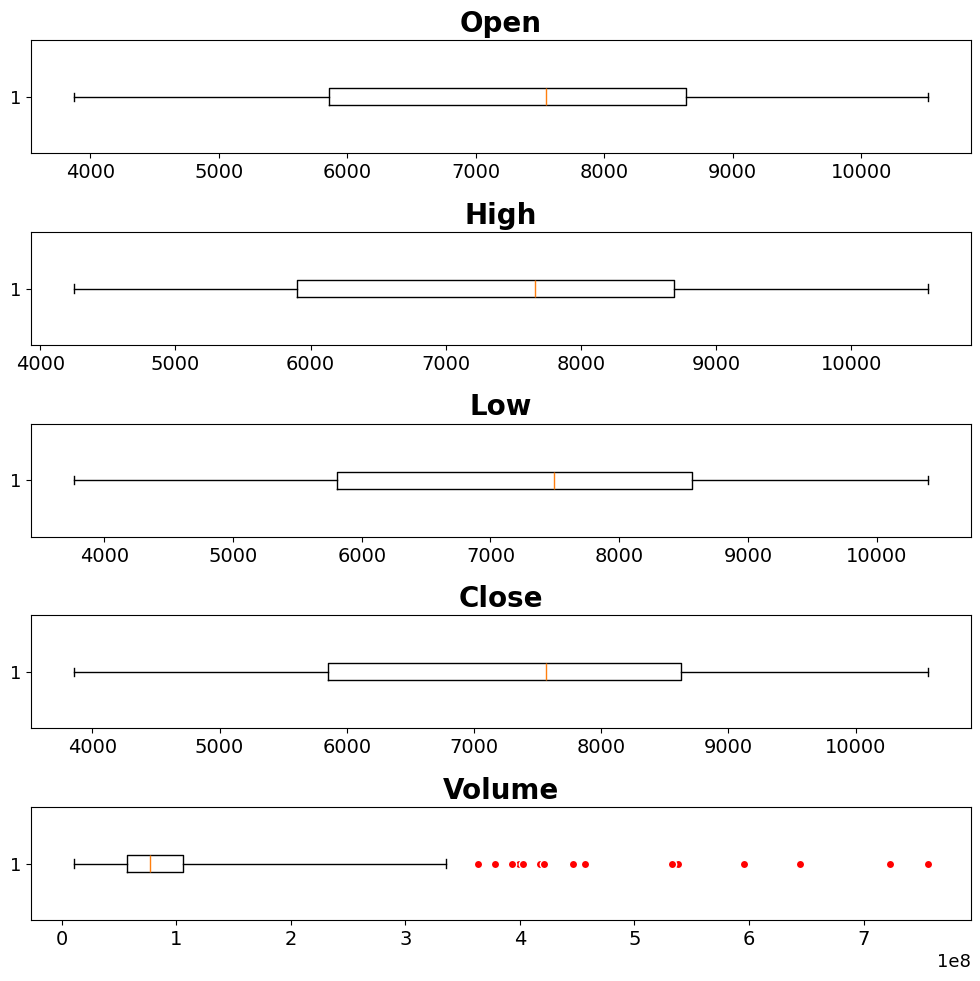

In [258]:
# Melihat distribusi sampel data dari Variabel OHLCV
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(len(data.columns), 1,  figsize=(10,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(data.iloc[:,i], flierprops=red_circle, vert = False, whis=5)
    ax.set_title(data.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='x', labelsize=14)

plt.tight_layout()
plt.show()

In [259]:
column_name = 'Volume'
target_data = data[column_name]

# Setelan whisker multiplier
whis_multiplier = 5.0

# Menghitung Q1, Q3, dan IQR
Q1 = target_data.quantile(0.25)
Q3 = target_data.quantile(0.75)
IQR = Q3 - Q1

# Menghitung batas atas dan bawah
upper_boundary = Q3 + (whis_multiplier * IQR)
lower_boundary = Q1 - (whis_multiplier * IQR)

# Mengidentifikasi outlier
outliers = target_data[(target_data > upper_boundary) | (target_data < lower_boundary)]
        
# Mencetak hasil perhitungan
print(f"--- Perhitungan Outlier untuk '{column_name}' (whis={whis_multiplier}) ---")
print(f"Q1 (Persentil 25): {Q1:,.2f}")
print(f"Q3 (Persentil 75): {Q3:,.2f}")
print(f"IQR (Q3 - Q1): {IQR:,.2f}")
print(f"--------------------------------------------------")
print(f"Batas Bawah (Q1 - {whis_multiplier}*IQR): {lower_boundary:,.2f}")
print(f"Batas Atas (Q3 + {whis_multiplier}*IQR): {upper_boundary:,.2f}")
print(f"--------------------------------------------------")

# Mencetak outlier yang ditemukan
print(f"Terdapat {len(outliers)} outlier pada variabel '{column_name}':")
# Menggunakan .to_string() untuk memastikan semua baris tercetak
print(outliers.to_string())

--- Perhitungan Outlier untuk 'Volume' (whis=5.0) ---
Q1 (Persentil 25): 57,417,950.00
Q3 (Persentil 75): 106,083,100.00
IQR (Q3 - Q1): 48,665,150.00
--------------------------------------------------
Batas Bawah (Q1 - 5.0*IQR): -185,907,800.00
Batas Atas (Q3 + 5.0*IQR): 349,408,850.00
--------------------------------------------------
Terdapat 15 outlier pada variabel 'Volume':
Date
2020-05-29    399414000.0
2020-09-11    403032500.0
2020-11-30    393091500.0
2021-05-27    537971500.0
2022-05-09    456796600.0
2022-09-16    363127600.0
2022-11-30    644359600.0
2023-05-31    722827900.0
2024-05-31    756431600.0
2025-03-18    417305700.0
2025-03-21    377916400.0
2025-04-08    533073600.0
2025-06-20    445915100.0
2025-09-01    421127500.0
2025-09-09    595368700.0


Skewness Volume Awal: 4.34
Skewness Volume (Log): 0.63


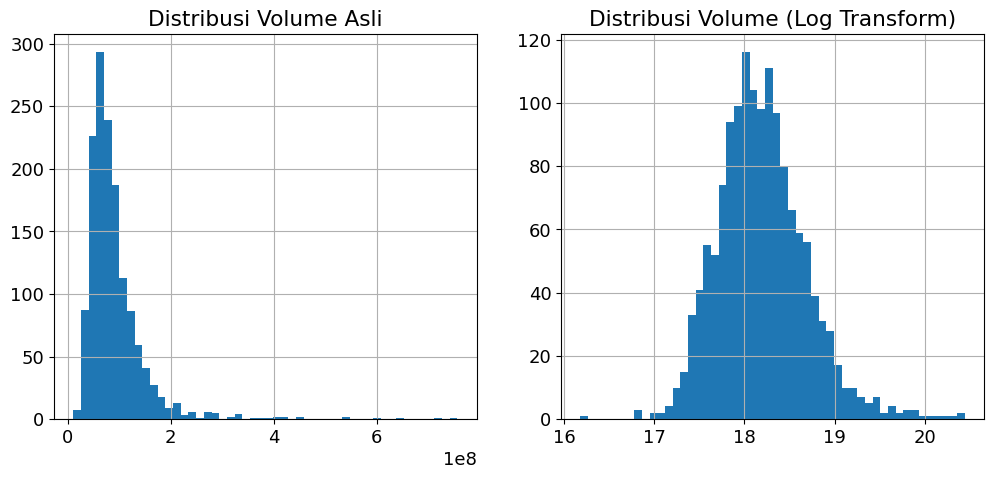

In [260]:
# Cek kemiringan 'Volume' sebelum transformasi
print(f"Skewness Volume Awal: {data['Volume'].skew():.2f}")

# Terapkan Log Transform 
data['Volume_Log'] = np.log1p(data['Volume']) # log1p untuk menghindari error jika ada volume 0

# Cek kemiringan setelah transformasi
print(f"Skewness Volume (Log): {data['Volume_Log'].skew():.2f}")

# Visualisasi perbedaannya
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
data['Volume'].hist(bins=50)
plt.title('Distribusi Volume Asli')

plt.subplot(1, 2, 2)
data['Volume_Log'].hist(bins=50)
plt.title('Distribusi Volume (Log Transform)')
plt.show()


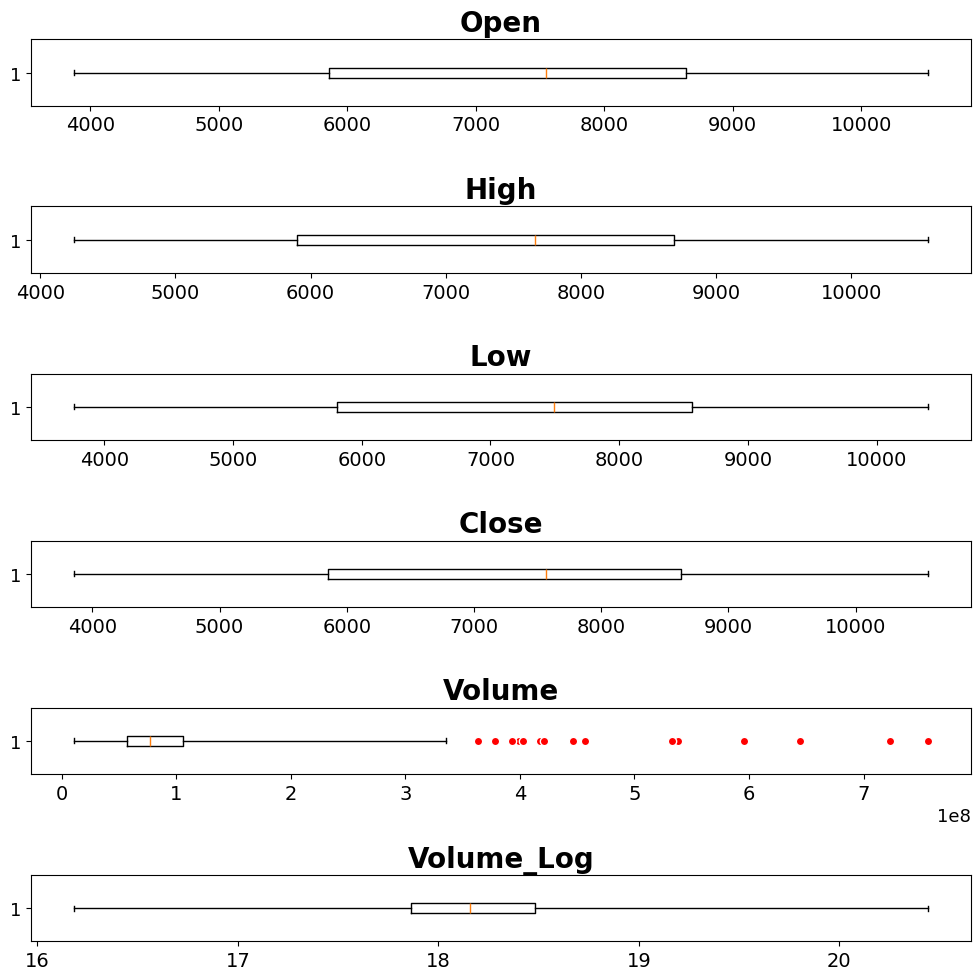

In [261]:
# Melihat distribusi sampel data dari Variabel OHLCV dan 'Volume_Log'
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(len(data.columns), 1,  figsize=(10,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(data.iloc[:,i], flierprops=red_circle, vert = False, whis=5)
    ax.set_title(data.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='x', labelsize=14)

plt.tight_layout()
plt.show()

In [262]:
data_olahan = data.drop('Volume', axis = 1)
data.head(10)

,Open,High,Low,Close,Volume,Volume_Log
Date,,,,,,
2019-10-01,5212.767129,5260.471321,5212.767129,5238.787598,40057000.0,17.505814
2019-10-02,5212.767466,5264.808406,5212.767466,5247.461426,52376500.0,17.773969
2019-10-03,5212.767129,5243.124342,5160.726193,5238.787598,50269000.0,17.732899
2019-10-04,5186.746829,5260.471491,5186.746829,5243.124512,56890500.0,17.856639
2019-10-07,5264.808105,5273.481595,5247.461127,5264.808105,56705500.0,17.853382
2019-10-08,5273.481634,5290.828613,5217.103952,5290.828613,46997500.0,17.665605
2019-10-09,5290.828574,5290.828574,5247.461127,5264.808105,41496500.0,17.541120
2019-10-10,5221.441031,5299.502441,5221.441031,5299.502441,65806500.0,18.002229
2019-10-11,5273.481990,5338.533166,5273.481990,5312.512695,40863500.0,17.525748


Data Transformation

Feature Engineering

In [263]:
# Membentuk variabel lag
def create_lagged_features(data_olahan):  
    df_fitur = pd.DataFrame(index=data_olahan.index)

    df_fitur['Close_Diff'] = data_olahan['Close'].diff(1)  
    df_fitur['Intraday_Range'] = data_olahan['High'] - data_olahan['Low']
    df_fitur['Intraday_Change'] = data_olahan['Close'] - data_olahan['Open']
    df_fitur['MA_5'] = talib.MA(data_olahan['Close'], timeperiod=5)
    df_fitur['MA_10'] = talib.MA(data_olahan['Close'], timeperiod=10)
    df_fitur['RSI_7'] = talib.RSI(data_olahan['Close'], timeperiod=7)
    df_fitur['RSI_14'] = talib.RSI(data_olahan['Close'], timeperiod=14)
    df_fitur['MOM_10'] = talib.MOM(data_olahan['Close'], timeperiod=10)
    df_fitur['ROC_10'] = talib.ROC(data_olahan['Close'], timeperiod=10)
    df_fitur['ATR_14'] = talib.ATR(data_olahan['High'], data_olahan['Low'], data_olahan['Close'], timeperiod=14)
    df_fitur['Volatility_10'] = df_fitur['Close_Diff'].rolling(window=10).std()
    
    df_fitur['Open_t-1'] = data_olahan['Open'].shift(1)
    df_fitur['High_t-1'] = data_olahan['High'].shift(1)
    df_fitur['Low_t-1'] = data_olahan['Low'].shift(1)
    df_fitur['Close_t-1'] = data_olahan['Close'].shift(1)
    df_fitur['Volume_Log_t-1'] = data_olahan['Volume_Log'].shift(1)
    df_fitur['Close_Diff_t-1'] = df_fitur['Close_Diff'].shift(1)
    df_fitur['Intraday_Range_t-1'] = df_fitur['Intraday_Range'].shift(1)
    df_fitur['Intraday_Change_t-1'] = df_fitur['Intraday_Change'].shift(1)    
    df_fitur['MA_5_t-1'] = df_fitur['MA_5'].shift(1)
    df_fitur['MA_10_t-1'] = df_fitur['MA_10'].shift(1)
    df_fitur['RSI_7_t-1'] = df_fitur['RSI_7'].shift(1)
    df_fitur['RSI_14_t-1'] = df_fitur['RSI_14'].shift(1)
    df_fitur['MOM_10_t-1'] = df_fitur['MOM_10'].shift(1)
    df_fitur['ROC_10_t-1'] = df_fitur['ROC_10'].shift(1)
    df_fitur['ATR_14_t-1'] = df_fitur['ATR_14'].shift(1)
    df_fitur['Volatility_10_t-1'] = df_fitur['Volatility_10'].shift(1)
    df_fitur['Intraday_Range_t-1'] = df_fitur['Intraday_Range'].shift(1)
    df_fitur['Intraday_Change_t-1'] = df_fitur['Intraday_Change'].shift(1)

    df_fitur['Year'] = df_fitur.index.year
    df_fitur['Month'] = df_fitur.index.month
    df_fitur['Week'] = df_fitur.index.isocalendar().week.astype(float)
    df_fitur['DayOfWeek'] = df_fitur.index.dayofweek
    df_fitur['DayOfMonth'] = df_fitur.index.day
    df_fitur['DayOfYear'] = df_fitur.index.dayofyear
    df_fitur['Quarter'] = df_fitur.index.quarter
    df_fitur['IsMonthStart'] = df_fitur.index.is_month_start.astype(int)
    df_fitur['IsMonthEnd'] = df_fitur.index.is_month_end.astype(int)

    df_fitur.dropna(inplace=True)

    return df_fitur

# Menggabungkan Variabel Tambahan ke dalam Data Olahan
df_fitur = create_lagged_features(data)

# Melihat Informasi Umum Terbaru dari Dara Olahan
df_fitur.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1432 entries, 2019-10-22 to 2025-09-30
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Close_Diff           1432 non-null   float64
 1   Intraday_Range       1432 non-null   float64
 2   Intraday_Change      1432 non-null   float64
 3   MA_5                 1432 non-null   float64
 4   MA_10                1432 non-null   float64
 5   RSI_7                1432 non-null   float64
 6   RSI_14               1432 non-null   float64
 7   MOM_10               1432 non-null   float64
 8   ROC_10               1432 non-null   float64
 9   ATR_14               1432 non-null   float64
 10  Volatility_10        1432 non-null   float64
 11  Open_t-1             1432 non-null   float64
 12  High_t-1             1432 non-null   float64
 13  Low_t-1              1432 non-null   float64
 14  Close_t-1            1432 non-null   float64
 15  Volume_Log_t-1      

In [264]:
df_fitur.head(5)

,Close_Diff,Intraday_Range,Intraday_Change,MA_5,MA_10,RSI_7,RSI_14,MOM_10,ROC_10,ATR_14,Volatility_10,Open_t-1,High_t-1,Low_t-1,Close_t-1,Volume_Log_t-1,Close_Diff_t-1,Intraday_Range_t-1,Intraday_Change_t-1,MA_5_t-1,MA_10_t-1,RSI_7_t-1,RSI_14_t-1,MOM_10_t-1,ROC_10_t-1,ATR_14_t-1,Volatility_10_t-1,Year,Month,Week,DayOfWeek,DayOfMonth,DayOfYear,Quarter,IsMonthStart,IsMonthEnd
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-22,69.388184,65.051177,26.020471,5379.298437,5350.675879,74.586306,72.322548,173.470215,3.278697,63.059875,48.894019,5377.563665,5425.267859,5364.553430,5394.910645,17.909380,52.041016,60.714428,17.346980,5357.614551,5333.328857,66.741535,67.647020,130.102539,2.471173,62.573082,45.575940,2019,10,43.0,1,22,295,4,0,0
2019-10-23,-21.684570,39.030700,-21.683722,5389.706543,5368.456494,68.679944,68.968147,177.806152,3.377258,61.343506,48.484211,5438.278358,5464.298828,5399.247652,5464.298828,18.024069,69.388184,65.051177,26.020471,5379.298437,5350.675879,74.586306,72.322548,173.470215,3.278697,63.059875,48.894019,2019,10,43.0,2,23,296,4,0,0
2019-10-24,21.684570,43.367451,8.673490,5421.798437,5384.936133,71.328774,70.444416,164.796387,3.109658,60.059502,48.153354,5464.297980,5468.634724,5429.604025,5442.614258,17.946171,-21.684570,39.030700,-21.683722,5389.706543,5368.456494,68.679944,68.968147,177.806152,3.377258,61.343506,48.484211,2019,10,43.0,3,24,297,4,0,0
2019-10-25,-86.734863,130.102354,-104.081883,5428.737305,5391.441260,51.144266,58.463956,65.051270,1.224492,65.062563,58.228475,5455.625338,5481.645809,5438.278358,5464.298828,18.107353,21.684570,43.367451,8.673490,5421.798437,5384.936133,71.328774,70.444416,164.796387,3.109658,60.059502,48.153354,2019,10,43.0,4,25,298,4,0,0
2019-10-28,4.336426,43.367449,4.336745,5426.135254,5391.874902,51.937578,58.840848,4.336426,0.080639,63.512912,54.490999,5481.645848,5485.982593,5355.880239,5377.563965,17.941507,-86.734863,130.102354,-104.081883,5428.737305,5391.441260,51.144266,58.463956,65.051270,1.224492,65.062563,58.228475,2019,10,44.0,0,28,301,4,0,0


Data Augmentation

In [265]:
data_keseluruhan = pd.concat([data_olahan, df_fitur], axis=1)
data_keseluruhan.dropna(inplace=True)
data_keseluruhan.head(5)

,Open,High,Low,Close,Volume_Log,Close_Diff,Intraday_Range,Intraday_Change,MA_5,MA_10,RSI_7,RSI_14,MOM_10,ROC_10,ATR_14,Volatility_10,Open_t-1,High_t-1,Low_t-1,Close_t-1,Volume_Log_t-1,Close_Diff_t-1,Intraday_Range_t-1,Intraday_Change_t-1,MA_5_t-1,MA_10_t-1,RSI_7_t-1,RSI_14_t-1,MOM_10_t-1,ROC_10_t-1,ATR_14_t-1,Volatility_10_t-1,Year,Month,Week,DayOfWeek,DayOfMonth,DayOfYear,Quarter,IsMonthStart,IsMonthEnd
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-22,5438.278358,5464.298828,5399.247652,5464.298828,18.024069,69.388184,65.051177,26.020471,5379.298437,5350.675879,74.586306,72.322548,173.470215,3.278697,63.059875,48.894019,5377.563665,5425.267859,5364.553430,5394.910645,17.909380,52.041016,60.714428,17.346980,5357.614551,5333.328857,66.741535,67.647020,130.102539,2.471173,62.573082,45.575940,2019.0,10.0,43.0,1.0,22.0,295.0,4.0,0.0,0.0
2019-10-23,5464.297980,5468.634724,5429.604025,5442.614258,17.946171,-21.684570,39.030700,-21.683722,5389.706543,5368.456494,68.679944,68.968147,177.806152,3.377258,61.343506,48.484211,5438.278358,5464.298828,5399.247652,5464.298828,18.024069,69.388184,65.051177,26.020471,5379.298437,5350.675879,74.586306,72.322548,173.470215,3.278697,63.059875,48.894019,2019.0,10.0,43.0,2.0,23.0,296.0,4.0,0.0,0.0
2019-10-24,5455.625338,5481.645809,5438.278358,5464.298828,18.107353,21.684570,43.367451,8.673490,5421.798437,5384.936133,71.328774,70.444416,164.796387,3.109658,60.059502,48.153354,5464.297980,5468.634724,5429.604025,5442.614258,17.946171,-21.684570,39.030700,-21.683722,5389.706543,5368.456494,68.679944,68.968147,177.806152,3.377258,61.343506,48.484211,2019.0,10.0,43.0,3.0,24.0,297.0,4.0,0.0,0.0
2019-10-25,5481.645848,5485.982593,5355.880239,5377.563965,17.941507,-86.734863,130.102354,-104.081883,5428.737305,5391.441260,51.144266,58.463956,65.051270,1.224492,65.062563,58.228475,5455.625338,5481.645809,5438.278358,5464.298828,18.107353,21.684570,43.367451,8.673490,5421.798437,5384.936133,71.328774,70.444416,164.796387,3.109658,60.059502,48.153354,2019.0,10.0,43.0,4.0,25.0,298.0,4.0,0.0,0.0
2019-10-28,5377.563646,5420.931095,5377.563646,5381.900391,17.582496,4.336426,43.367449,4.336745,5426.135254,5391.874902,51.937578,58.840848,4.336426,0.080639,63.512912,54.490999,5481.645848,5485.982593,5355.880239,5377.563965,17.941507,-86.734863,130.102354,-104.081883,5428.737305,5391.441260,51.144266,58.463956,65.051270,1.224492,65.062563,58.228475,2019.0,10.0,44.0,0.0,28.0,301.0,4.0,0.0,0.0


In [266]:
data_keseluruhan.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1432 entries, 2019-10-22 to 2025-09-30
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Open                 1432 non-null   float64
 1   High                 1432 non-null   float64
 2   Low                  1432 non-null   float64
 3   Close                1432 non-null   float64
 4   Volume_Log           1432 non-null   float64
 5   Close_Diff           1432 non-null   float64
 6   Intraday_Range       1432 non-null   float64
 7   Intraday_Change      1432 non-null   float64
 8   MA_5                 1432 non-null   float64
 9   MA_10                1432 non-null   float64
 10  RSI_7                1432 non-null   float64
 11  RSI_14               1432 non-null   float64
 12  MOM_10               1432 non-null   float64
 13  ROC_10               1432 non-null   float64
 14  ATR_14               1432 non-null   float64
 15  Volatility_10       

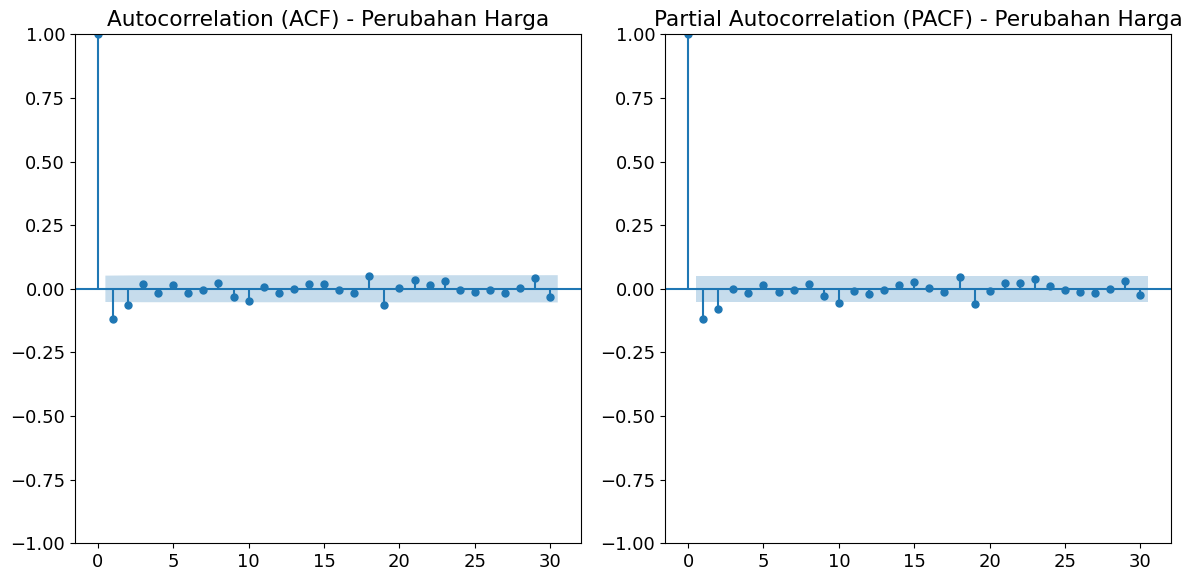

In [267]:
# Melakukan Visualisasi ACF dan PACF dari Variabel 'Close_Diff'
plt.figure(figsize= (12,6))

# Plot ACF dari Variabel 'Close_Diff1'
plt.subplot(121)
plot_acf(data_keseluruhan['Close_Diff'], lags=30, ax=plt.gca(), title= 'Autocorrelation (ACF) - Perubahan Harga')

# Plot PACF dari Variabel 'Close_Diff1'
plt.subplot(122)
plot_pacf(data_keseluruhan['Close_Diff'], lags=30, ax=plt.gca(), title = 'Partial Autocorrelation (PACF) - Perubahan Harga')

plt.tight_layout()
plt.show()

array([[<Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>,
        <Axes: title={'center': 'Low'}>,
        <Axes: title={'center': 'Close'}>,
        <Axes: title={'center': 'Volume_Log'}>,
        <Axes: title={'center': 'Close_Diff'}>],
       [<Axes: title={'center': 'Intraday_Range'}>,
        <Axes: title={'center': 'Intraday_Change'}>,
        <Axes: title={'center': 'MA_5'}>,
        <Axes: title={'center': 'MA_10'}>,
        <Axes: title={'center': 'RSI_7'}>,
        <Axes: title={'center': 'RSI_14'}>],
       [<Axes: title={'center': 'MOM_10'}>,
        <Axes: title={'center': 'ROC_10'}>,
        <Axes: title={'center': 'ATR_14'}>,
        <Axes: title={'center': 'Volatility_10'}>,
        <Axes: title={'center': 'Open_t-1'}>,
        <Axes: title={'center': 'High_t-1'}>],
       [<Axes: title={'center': 'Low_t-1'}>,
        <Axes: title={'center': 'Close_t-1'}>,
        <Axes: title={'center': 'Volume_Log_t-1'}>,
        <Axes: title={'center': 'Clos

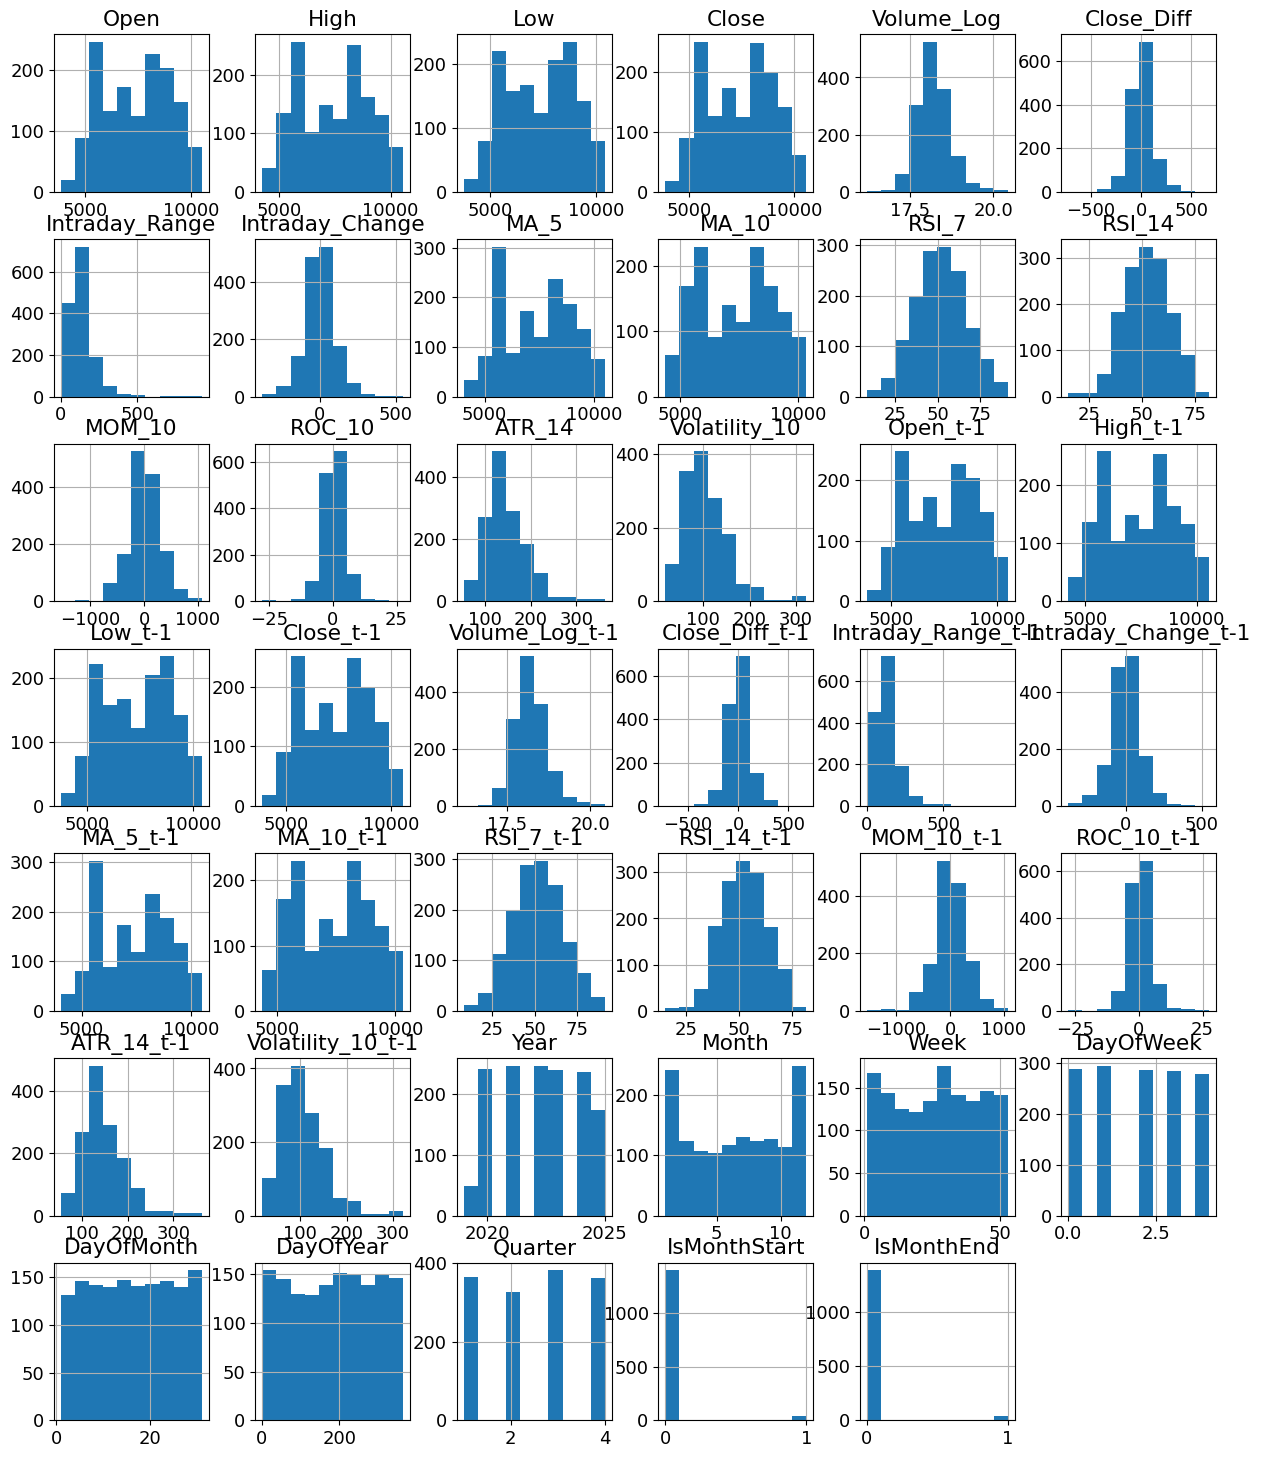

In [268]:
# Melihat Distribusi dari Setiap Variabel dalam Data Olahan
data_keseluruhan.hist(figsize=(15,18))

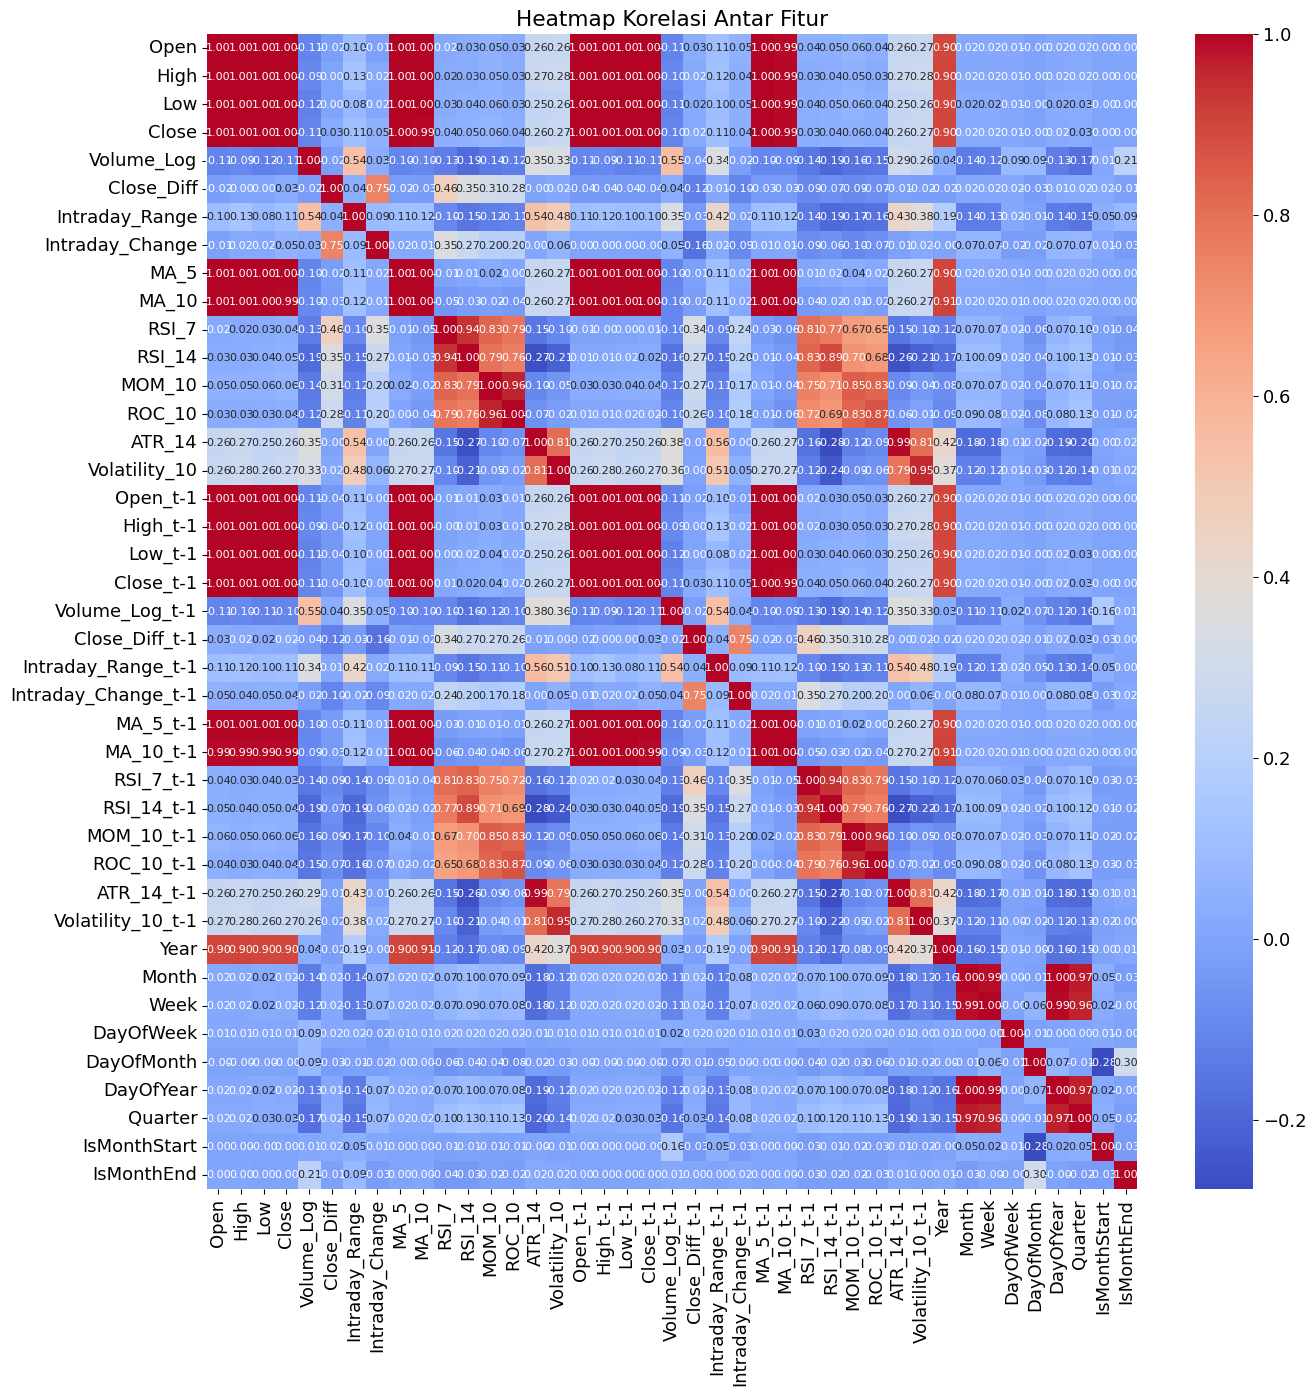

In [269]:
# Membuat Correlation Matrix dari Setiap Variabel
plt.figure(figsize=(15, 15))
correlation_matrix = data_keseluruhan.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 8})
plt.title('Heatmap Korelasi Antar Fitur')
plt.show()

Data Splitting

In [270]:
# Melakukan Features Selection, memilih variabel sebagai input dan output
features = [col for col in data_keseluruhan.columns if col not in ['Open',
                                                                   'High',
                                                                   'Low',
                                                                   'Volume_Log',
                                                                   'Close',                                                                   
                                                                   'Close_Diff',
                                                                   'Intraday_Range',
                                                                   'Intraday_Change',
                                                                   'MA_5',
                                                                   'MA_10',
                                                                   'RSI_7',
                                                                   'RSI_14',
                                                                   'MOM_10',
                                                                   'ROC_10',
                                                                   'ATR_14',
                                                                   'Volatility_10']]
X = data_keseluruhan[features]
y = data_keseluruhan['Close_Diff']

# Menetapkan ukuran data latih sebesar 80% dari keseluruhan data olahan
train_size = int(len(data_keseluruhan) * 0.8)

# Menyesuaikan komposisi data latih dan data uji terhadap variabel input dan variabel ouptut
X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
X_test = X.iloc[train_size:]
y_test = y.iloc[train_size:]

### IMPLEMENTASI MODEL RANDOM FOREST

MODEL DEVELOPMENT

In [271]:
# Inisiasi Model Random Forest
rf = RandomForestRegressor(random_state=42,
                           n_jobs=-1)

# Melatih Model Random Forest dengan Data Latih
rf.fit(X_train, y_train)

# Model Random Forest melakuakan peramalan berdasarkan Data Uji
y_pred = rf.predict(X_test)


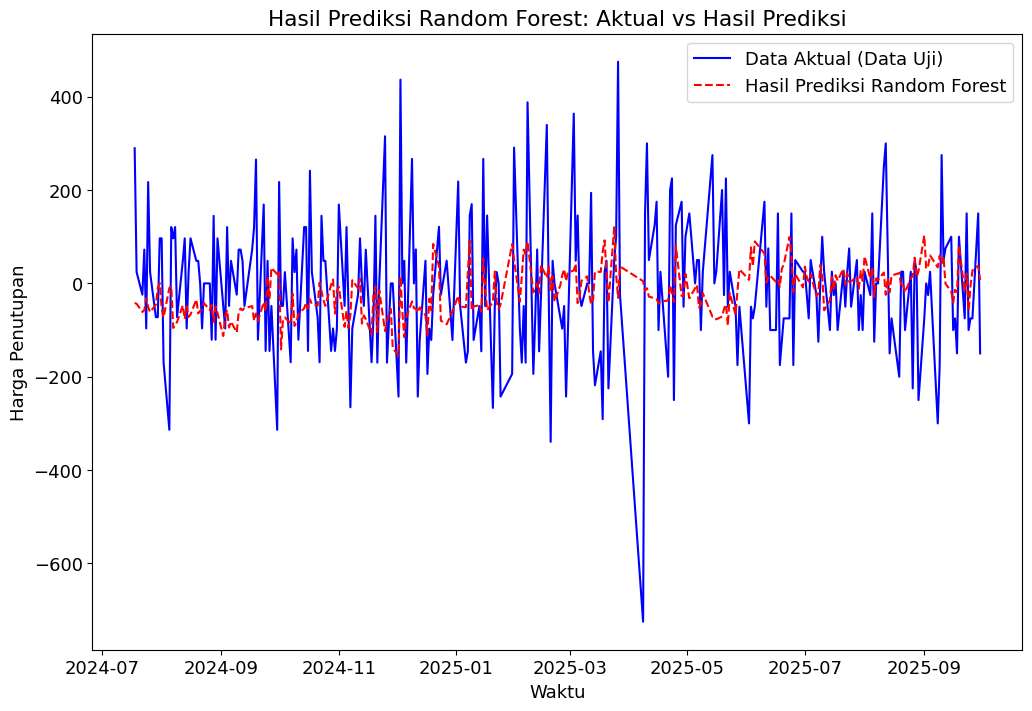

In [272]:
# Plotting hasil peramalan model Random Forest tanpa Hyperparameter Tuning
plt.figure(figsize=(12, 8))
plt.plot(y_test.index, y_test, label='Data Aktual (Data Uji)', color='blue')
plt.plot(y_test.index, y_pred, label='Hasil Prediksi Random Forest', color='red', linestyle='--')
plt.title('Hasil Prediksi Random Forest: Aktual vs Hasil Prediksi')
plt.xlabel('Waktu')
plt.ylabel('Harga Penutupan')
plt.legend()
plt.show()

MODEL EVALUATION

In [273]:
# Melihat akurasi model Random Forest tanpa Hyperparameter Tuning
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)
print('R-squared:', r_squared)

RMSE: 152.42898465470077
MAE: 118.13668457881916
MAPE: 1.3915669405382278e+16
R-squared: -0.08629259490089658


In [274]:
# Melihat Feature Importances, tingkat kontribusi setiap variabel input dalam model Random Forest tanpa Hyperparameter Tuning
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

display(importances_sorted)

Close_Diff_t-1         0.082622
Intraday_Range_t-1     0.077963
Intraday_Change_t-1    0.068197
ATR_14_t-1             0.067994
Volatility_10_t-1      0.066489
Volume_Log_t-1         0.066213
RSI_14_t-1             0.064243
RSI_7_t-1              0.059303
DayOfMonth             0.053098
MA_10_t-1              0.045753
MOM_10_t-1             0.045465
MA_5_t-1               0.043190
ROC_10_t-1             0.042073
DayOfYear              0.039939
Open_t-1               0.030285
Low_t-1                0.027997
Close_t-1              0.027591
High_t-1               0.025291
DayOfWeek              0.020876
Week                   0.018653
IsMonthEnd             0.008660
Month                  0.007864
Quarter                0.004845
Year                   0.004450
IsMonthStart           0.000944
dtype: float64

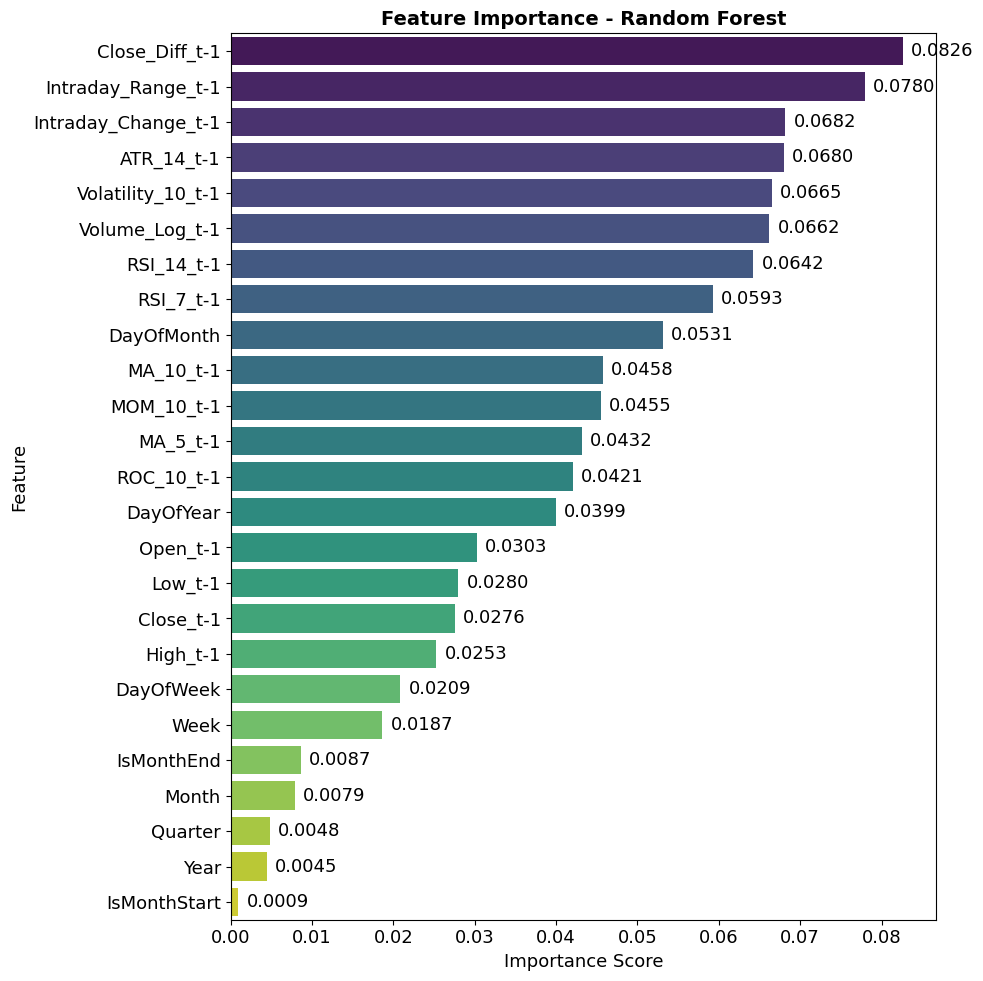

In [275]:
# Visualisasi tingkat kontribusi setiap variabel input dalam model Random Forest tanpa Hyperparameter Tuning
plt.figure(figsize=(10, 10))

ax = sns.barplot(
    x=importances_sorted.values,
    y=importances_sorted.index,
    palette="viridis"
)

for i, v in enumerate(importances_sorted.values):
    ax.text(v + 0.001, i, f"{v:.4f}", color='black', va='center')

plt.title("Feature Importance - Random Forest", fontsize=14, weight='bold')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Implementasi Model Random Forest dengan Hyperparameter Tuning Bayesian Optimization

MODEL DEVELOPMENT

Algoritma Bayesian Optimization

In [276]:
# Melakukan TimeSeriesSplit cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Definisikan Parameter Bounds (pbounds) untuk BayesianOptimization
pbounds = {
    'n_estimators': (200, 1000),         
    'max_depth': (5, 50),             
    'min_samples_leaf': (1, 15),       
    'min_samples_split': (2, 20),
    'max_features': (0.1, 1.0)
}

def rf_cv_score(n_estimators, max_depth, min_samples_leaf, max_features, min_samples_split):
    try:
        n_estimators = int(n_estimators)
        max_depth = int(max_depth)
        min_samples_leaf = int(min_samples_leaf)
        min_samples_split = int(min_samples_split)

        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            min_samples_split=min_samples_split,
            random_state=42,
            n_jobs=-1
        )

        scores = cross_val_score(
            model,
            X_train,
            y_train,
            cv=tscv,
            scoring='neg_root_mean_squared_error', 
            n_jobs=-1
        )

        return np.mean(scores)

    except Exception as e:
        print(f"Error dengan parameter: {e}")
        return -1e9 

optimizer = BayesianOptimization(
    f=rf_cv_score,  # Fungsi yang akan dioptimalkan
    pbounds=pbounds,  # Batasan parameter
    random_state=42,
    verbose=2  
)

optimizer.maximize(
    init_points=5,  
    n_iter=50) 

best_params = optimizer.max['params']

n_est_best = int(best_params['n_estimators'])
m_depth_best = int(best_params['max_depth'])
m_leaf_best = int(best_params['min_samples_leaf'])
m_split_best= int(best_params['min_samples_split'])
m_feat_best = best_params['max_features']

print(f"Hyperparameter terbaik: n_estimators={n_est_best}, max_depth={m_depth_best}, min_samples_leaf={m_leaf_best}, min_samples_split={m_split_best}, max_features='{m_feat_best}'")

|   iter    |  target   | n_esti... | max_depth | min_sa... | min_sa... | max_fe... |
-------------------------------------------------------------------------------------
| 1         | -100.8907 | 499.63209 | 47.782143 | 11.247915 | 12.775852 | 0.2404167 |
| 2         | -101.2318 | 324.79561 | 7.6137625 | 13.126466 | 12.820070 | 0.7372653 |
| 3         | -100.9782 | 216.46759 | 48.645943 | 12.654196 | 5.8221039 | 0.2636424 |
| 4         | -101.8668 | 346.72360 | 18.690900 | 8.3465900 | 9.7750103 | 0.3621062 |
| 5         | -102.3619 | 689.48231 | 11.277223 | 5.0900250 | 8.5945131 | 0.5104629 |
| 6         | -100.5253 | 499.93648 | 47.350519 | 12.293858 | 13.315706 | 0.1       |
| 7         | -100.3493 | 500.85939 | 45.904440 | 14.064357 | 15.104180 | 0.1       |
| 8         | -100.3277 | 504.11640 | 48.545910 | 15.0      | 12.861782 | 0.1       |
| 9         | -100.3216 | 502.35924 | 43.566001 | 15.0      | 9.9334777 | 0.1       |
| 10        | -100.3410 | 508.86377 | 42.640869 | 14.5

Model Random Forest dengan Hyperparameter Tuning
menggunakan Bayesian Optimization

In [277]:
best_rf_model = RandomForestRegressor(
    n_estimators=n_est_best,
    max_depth=m_depth_best,
    min_samples_leaf=m_leaf_best,
    min_samples_split=m_split_best,
    max_features=m_feat_best,
    random_state=42,
    n_jobs=-1
)

best_rf_model.fit(X_train, y_train)

y_pred = best_rf_model.predict(X_test)

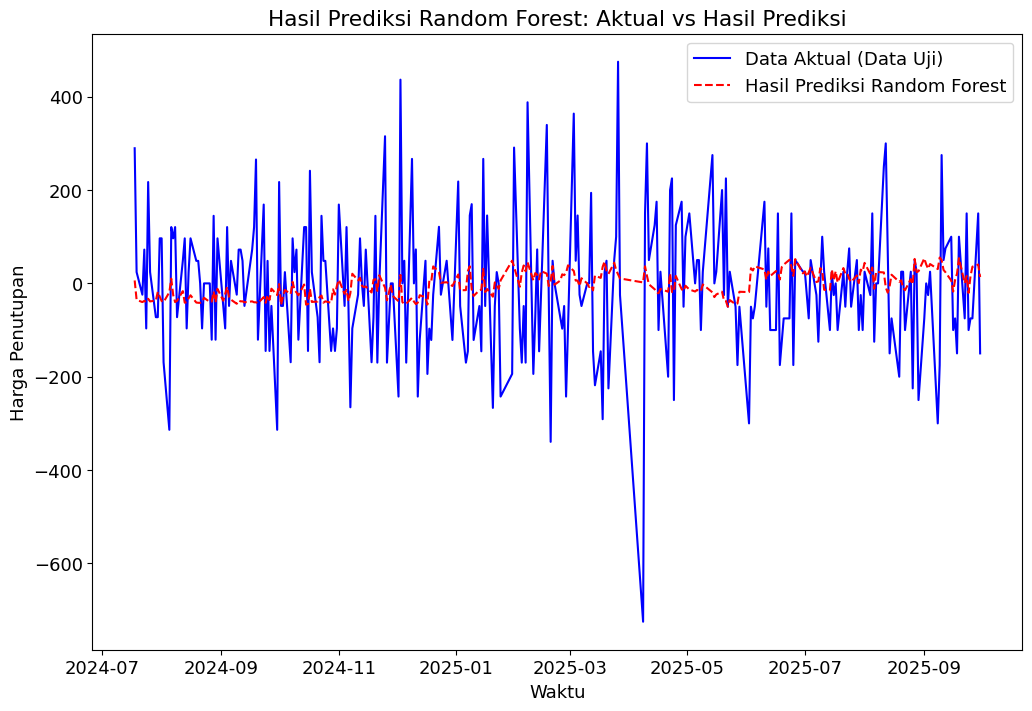

In [278]:
plt.figure(figsize=(12, 8))
plt.plot(y_test.index, y_test, label='Data Aktual (Data Uji)', color='blue')
plt.plot(y_test.index, y_pred, label='Hasil Prediksi Random Forest', color='red', linestyle='--')
plt.title('Hasil Prediksi Random Forest: Aktual vs Hasil Prediksi')
plt.xlabel('Waktu')
plt.ylabel('Harga Penutupan')
plt.legend()
plt.show()

MODEL EVALUATION

In [279]:
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)
print('R-squared:', r_squared)

RMSE: 146.04708510213757
MAE: 112.13088293684544
MAPE: 7244745105744416.0
R-squared: 0.0027650461254710157


In [280]:
# Melihat Feature Importances, tingkat kontribusi setiap variabel input dalam model Random Forest dengan Hyperparameter Tuning Bayesian Optimization
importances = pd.Series(best_rf_model.feature_importances_, index=X.columns)

importances_sorted = importances.sort_values(ascending=False)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

display(importances_sorted)

Close_Diff_t-1         0.074523
RSI_7_t-1              0.057561
Intraday_Change_t-1    0.056754
ROC_10_t-1             0.054492
MA_10_t-1              0.052641
MOM_10_t-1             0.052308
ATR_14_t-1             0.050920
RSI_14_t-1             0.049417
Volume_Log_t-1         0.049295
Volatility_10_t-1      0.049247
MA_5_t-1               0.048978
High_t-1               0.048421
Intraday_Range_t-1     0.046911
Close_t-1              0.046521
Open_t-1               0.045517
Low_t-1                0.044859
DayOfYear              0.043033
DayOfMonth             0.035905
Week                   0.030592
Month                  0.019609
DayOfWeek              0.016627
Year                   0.013740
Quarter                0.011148
IsMonthEnd             0.000715
IsMonthStart           0.000264
dtype: float64

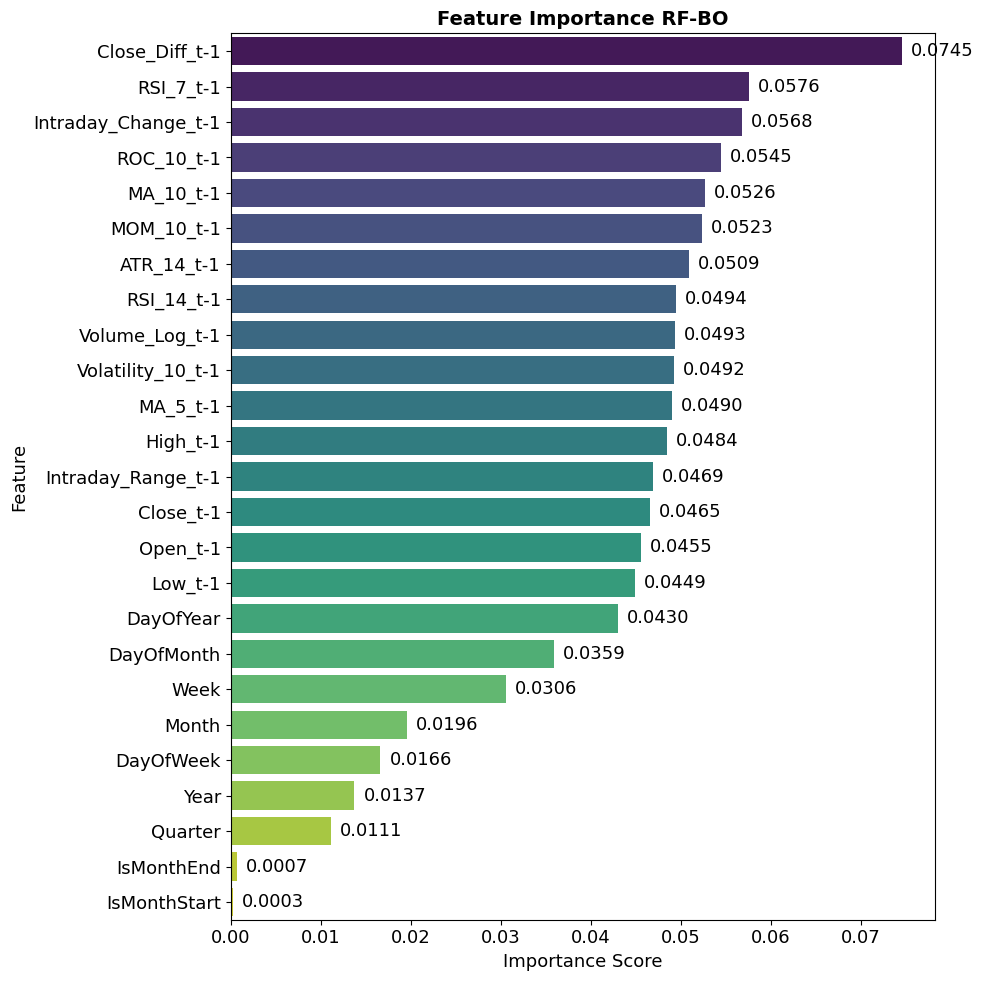

In [281]:
# Visualisasi tingkat kontribusi setiap variabel input dalam model Random Forest dengan Hyperparameter Tuning Bayesian Optimization
plt.figure(figsize=(10, 10))

ax = sns.barplot(
    x=importances_sorted.values,
    y=importances_sorted.index,
    palette="viridis"
)

for i, v in enumerate(importances_sorted.values):
    ax.text(v + 0.001, i, f"{v:.4f}", color='black', va='center')

plt.title("Feature Importance RF-BO", fontsize=14, weight='bold')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

MODEL POSTPROCESSING


RMSE (Baru): 146.04708510213757
MAE (Baru): 112.13088293684542
MAPE (Baru): 0.012384705429563637
R-squared (Baru): 0.9630337743645088


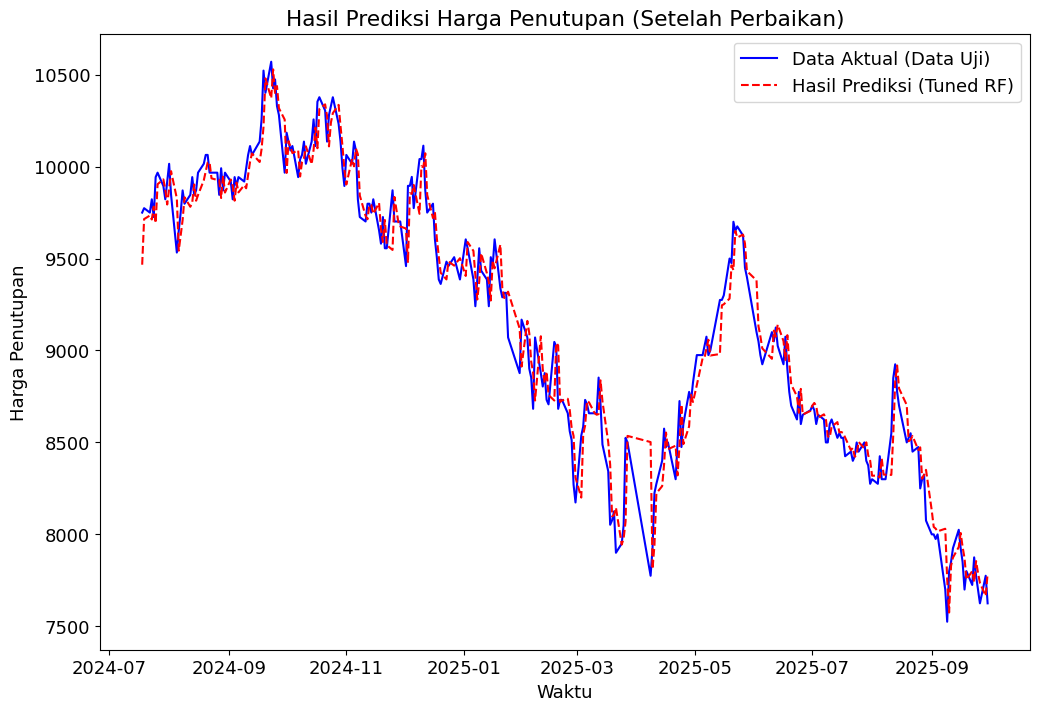

In [282]:
y_pred = best_rf_model.predict(X_test)
close_t_minus_1_test = data_keseluruhan.loc[X_test.index, 'Close_t-1']
close_actual_test = data_keseluruhan.loc[X_test.index, 'Close']
close_pred = close_t_minus_1_test + y_pred

hasil_df = pd.DataFrame({
    'Close_Actual': close_actual_test,
    'Close_Predicted': close_pred,
    'Pred_Close_Diff': y_pred
}, index=X_test.index)


rmse_new = root_mean_squared_error(hasil_df['Close_Actual'], hasil_df['Close_Predicted'])
mae_new = mean_absolute_error(hasil_df['Close_Actual'], hasil_df['Close_Predicted'])
mape_new = mean_absolute_percentage_error(hasil_df['Close_Actual'], hasil_df['Close_Predicted'])
r_squared_new = r2_score(hasil_df['Close_Actual'], hasil_df['Close_Predicted'])

print('RMSE (Baru):', rmse_new)
print('MAE (Baru):', mae_new)
print('MAPE (Baru):', mape_new)
print('R-squared (Baru):', r_squared_new)

plt.figure(figsize=(12, 8))
plt.plot(hasil_df.index, hasil_df['Close_Actual'], label='Data Aktual (Data Uji)', color='blue')
plt.plot(hasil_df.index, hasil_df['Close_Predicted'], label='Hasil Prediksi (Tuned RF)', color='red', linestyle='--')
plt.title('Hasil Prediksi Harga Penutupan (Setelah Perbaikan)')
plt.xlabel('Waktu')
plt.ylabel('Harga Penutupan')
plt.legend()
plt.show()

In [283]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

display(hasil_df)


,Close_Actual,Close_Predicted,Pred_Close_Diff
Date,,,
2024-07-18,9749.879883,9466.543224,6.263927
2024-07-19,9774.013672,9714.593659,-35.286224
2024-07-22,9749.879883,9733.946069,-40.067603
2024-07-23,9822.280273,9712.403443,-37.476440
2024-07-24,9725.746094,9782.374016,-39.906257
2024-07-25,9942.946289,9692.768566,-32.977528
2024-07-26,9967.080078,9904.316516,-38.629773
2024-07-29,9894.679688,9930.434083,-36.645995
2024-07-30,9822.280273,9876.543590,-18.136098
